In [30]:
import numpy as np
import pandas as pd
from dside import DSI
import matplotlib.pyplot as plt
import GPy
from smt.sampling_methods import LHS
from kernel_opt_fun import *

In [ ]:
#Generate LHS training samples
xlimits = np.array([
    [0,1],
    [0,1], 
    [0,50],
    [0, 240]
])
sampling = LHS(xlimits=xlimits, criterion='ese')

n = 500

x_LHS = sampling(n)

# Define the objective function
def f(X):
    
    return 0.6224* X[:, 0]* X[:, 2]* X[:, 3] + 1.7781* X[:, 1]* X[:, 2]**2 + 3.1661* X[:, 0]**2* X[:, 3] + 19.84* X[:, 0]**2*X[:, 2]

# Create input X arrays
X1 = x_LHS[:,0]
X2 = x_LHS[:,1]
X3 = x_LHS[:,2]
X4 = x_LHS[:,3]



In [ ]:
X = np.vstack((X1.flatten(), X2.flatten(), X3.flatten(), X4.flatten())).T
Y = f(X).reshape(-1, 1)

# Create and train the GP model
best_kernel, best_mea = find_best_kernel(X, Y, input_dim=4)
print("Best kernel:", kernel_to_str(best_kernel))
print("Best MEA:", best_mea)

model = GPy.models.GPRegression(X, Y, best_kernel)


In [ ]:

# Fit the model
model.optimize(messages=True)



Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0008   2.581665e+02   1.591100e+03 
    00s12  0025   2.566014e+02   1.417207e+03 
    00s24  0049   2.541048e+02   1.125109e+04 
Runtime:     00s24
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



In [ ]:


# Re-generate sample points for plotting (finer grid)
n = 20
X1 = np.linspace(0,1, n)
X2 = np.linspace(0,1, n)
X3 = np.linspace(0, 50, n)
X4 = np.linspace(0, 240, n)
X1, X2, X3, X4 = np.meshgrid(X1, X2, X3, X4)
X = np.vstack((X1.flatten(), X2.flatten(), X3.flatten(), X4.flatten())).T
Y = f(X).reshape(-1, 1)

# Predict
X_pred = X
Y_pred, Y_pred_var = model.predict(X_pred)

Y_true = Y
Y_pred = Y_pred.reshape(-1,1)


In [ ]:
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error 

MAE = mean_absolute_error(Y_true, Y_pred)
#MAPE = mean_absolute_percentage_error(Y_true, Y_pred)
print(f"MAE = {MAE:.3f}")
#print(f"MAPE = {MAPE*100:.2f}%")


MAE = 0.012
MAPE = 40901199636531.58%


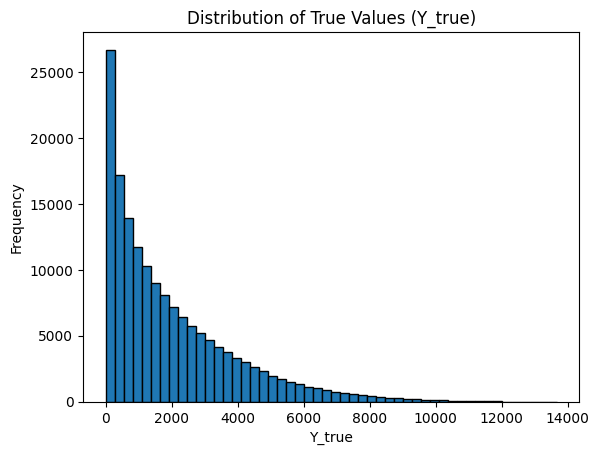

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of Y_true
plt.hist(Y_true, bins=50, edgecolor='black')
plt.title("Distribution of True Values (Y_true)")
plt.xlabel("Y_true")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Calculate the percentage of small values baaed on Ytrue
threshold = 1e-3
percentsmallY = percentage_small_values(Y_true, threshold)

print(f"Percentage of small true values (|Y_true| < {threshold}): {percentsmallY:.2f}%")


Percentage of small true values (|Y_true| < 0.001): 0.73%


In [ ]:

# Calculate custom MAPE
custom_MAPE = custom_mape(Y_true, Y_pred)
print(f"Custom MAPE = {custom_MAPE:.2f}%")


Custom MAPE = 9.09%


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
R2score = r2_score(Y_true, Y_pred)
MSE = mean_squared_error(Y_true, Y_pred)
print(f"R2 = {R2score:.2f}")
print(f"MSE = {MSE:.5f}")

R2 = 1.00
MSE = 0.00031


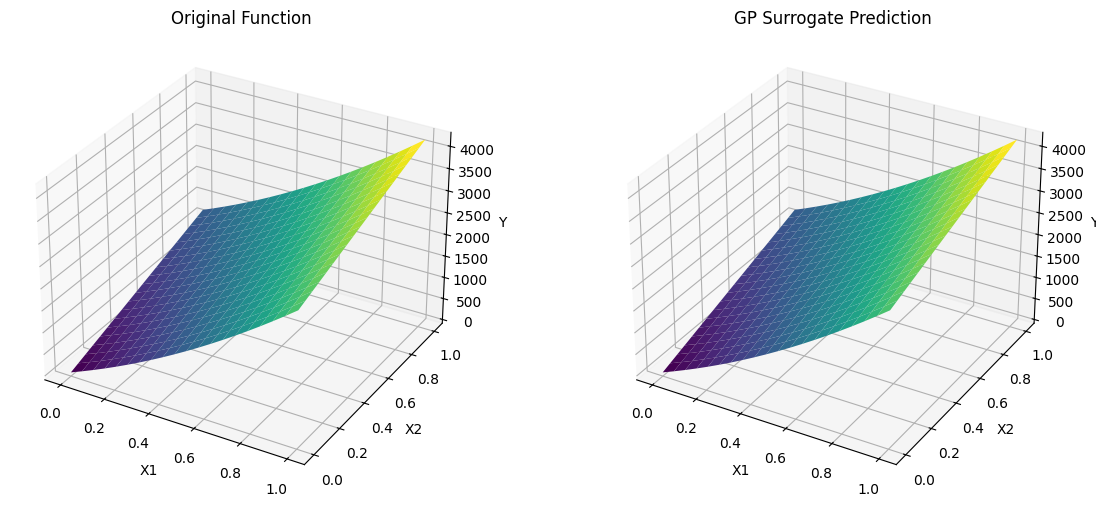

In [ ]:
# Note: Plotting a 3D surface is not directly possible for 4D data (X1, X2, X3, Y).
# So we will plot slices or projections. Here we plot a slice where X3 is fixed.
# Reshape for plotting
Y_pred = Y_pred.reshape(X1.shape)
Y_true = f(X_pred).reshape(X1.shape)

# Select fixed slices for X3 and X4 for visualization
slice_index_X3 = n // 2
slice_index_X4 = n // 2
X1_slice = X1[:, :, slice_index_X3, slice_index_X4]
X2_slice = X2[:, :, slice_index_X3, slice_index_X4]
Y_true_slice = Y_true[:, :, slice_index_X3, slice_index_X4]
Y_pred_slice = Y_pred[:, :, slice_index_X3, slice_index_X4]

# Plotting
fig = plt.figure(figsize=(14, 6))

# Original data
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_slice, X2_slice, Y_true_slice, cmap='viridis')
ax1.set_title('Original Function')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')

# Surrogate model prediction
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_slice, X2_slice, Y_pred_slice, cmap='viridis')
ax2.set_title('GP Surrogate Prediction')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Y')

plt.show()

Text(0.5, 0, 'Residuals')

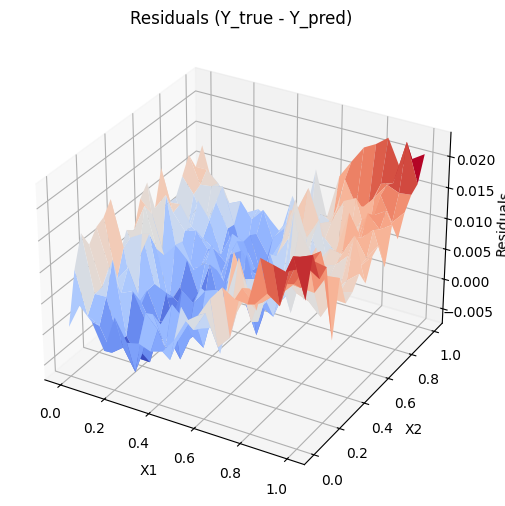

In [ ]:
# Calculate residuals
residuals = Y_true_slice - Y_pred_slice

# # Plotting
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_slice, X2_slice, residuals, cmap='coolwarm')
ax1.set_title('Residuals (Y_true - Y_pred)')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Residuals')


In [ ]:
# Flatten the arrays
X1_flat = X1.flatten()
X2_flat = X2.flatten()
X3_flat = X3.flatten()
X4_flat = X4.flatten()
Y_true_flat = Y_true.flatten()
Y_pred_flat = Y_pred.flatten()

# Create a DataFrame
data = {
    'X1': X1_flat,
    'X2': X2_flat,
    'X3': X3_flat,
    'X4': X4_flat,
    'Y_true': Y_true_flat,
    'Y_pred': Y_pred_flat,
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

         X1   X2    X3          X4        Y_true        Y_pred
0       0.0  0.0   0.0    0.000000      0.000000      0.000000
1       0.0  0.0   0.0   12.631579      0.000000     -0.000006
2       0.0  0.0   0.0   25.263158      0.000000     -0.000051
3       0.0  0.0   0.0   37.894737      0.000000     -0.000364
4       0.0  0.0   0.0   50.526316      0.000000     -0.000412
...     ...  ...   ...         ...           ...           ...
159995  1.0  1.0  50.0  189.473684  11933.563684  11933.556458
159996  1.0  1.0  50.0  202.105263  12366.651263  12366.630127
159997  1.0  1.0  50.0  214.736842  12799.738842  12799.695129
159998  1.0  1.0  50.0  227.368421  13232.826421  13232.808838
159999  1.0  1.0  50.0  240.000000  13665.914000  13665.916626

[160000 rows x 6 columns]


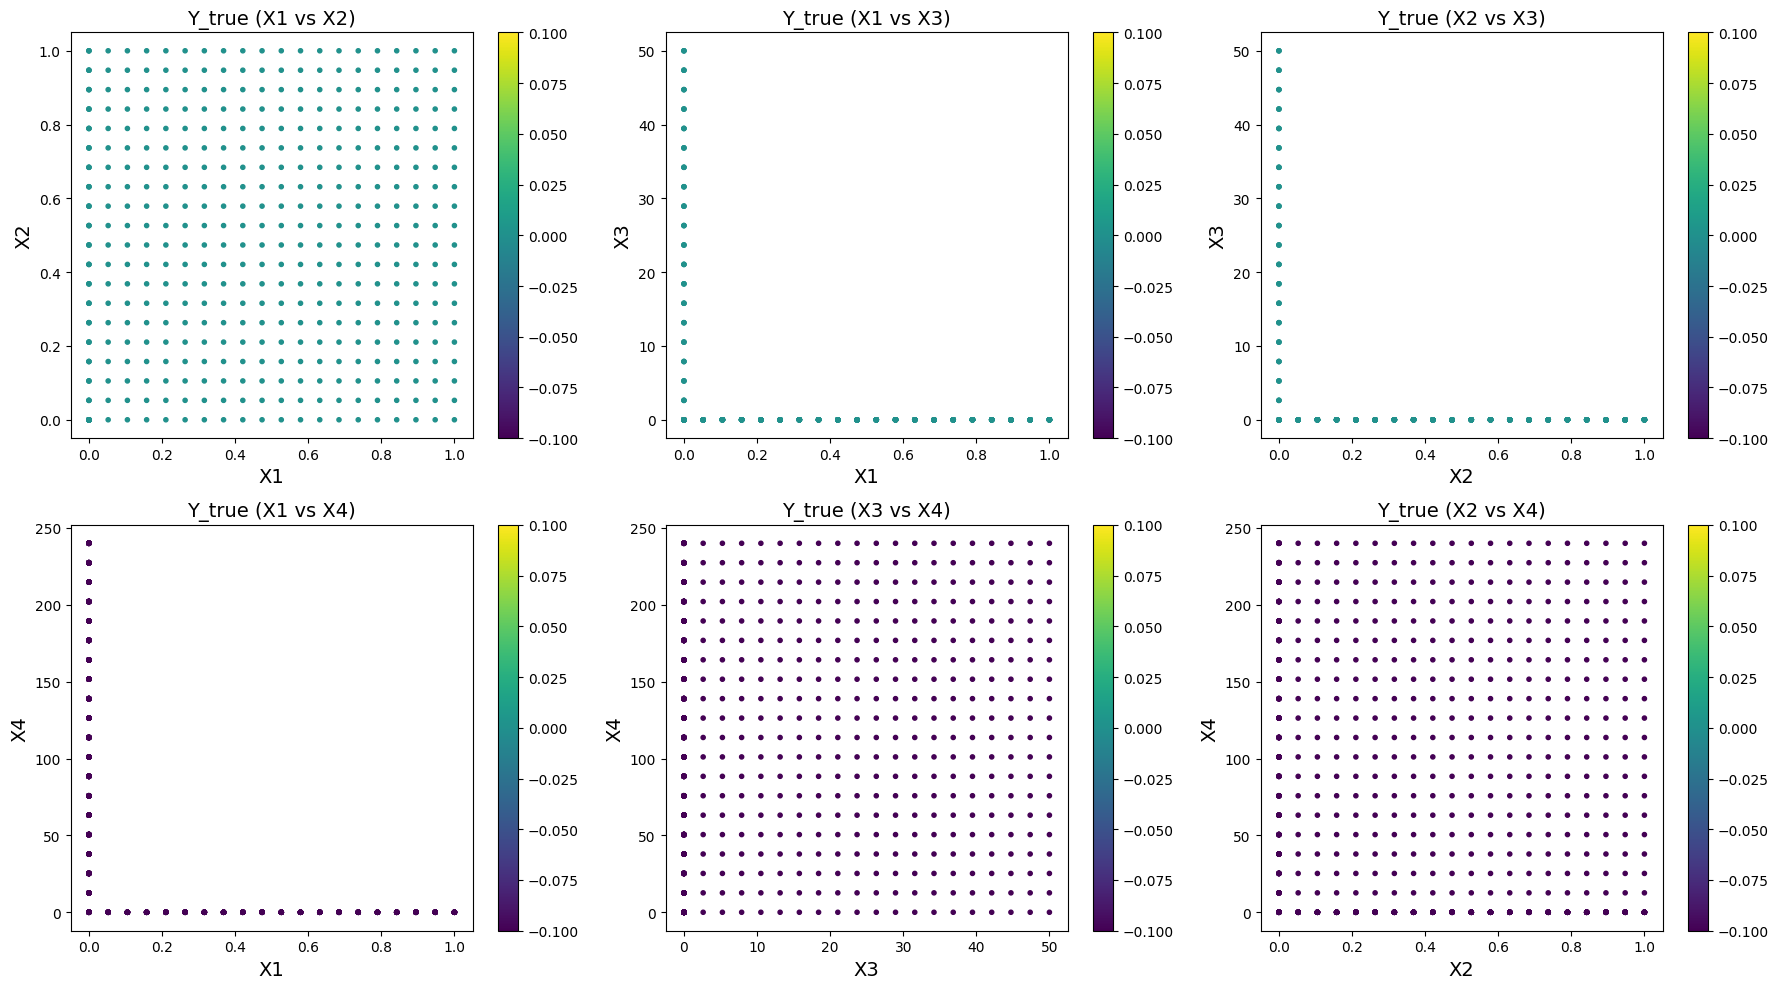

In [ ]:
#cut through a point 2D plots

#2D plots
ptol = 20 #plots work just barely anything passess through 0
pp = 0 #NP = [0.5, 0.5, 25, 120] #midranges since that the NP explored 
# fm_X1 = ((df['Y_true'] <= 0 ) & ((df['X1'] < pp + ptol) & (df['X1'] > pp - ptol)))
# fm_X2 = ((df['Y_true'] <= 0 ) & ((df['X2'] < pp + ptol) & (df['X2'] > pp - ptol)))
# fm_X3 = ((df['Y_true'] <= 0 ) & ((df['X3'] < pp + ptol) & (df['X3'] > pp - ptol)))
# fm_X4 = ((df['Y_true'] <= 0 ) & ((df['X4'] < pp + ptol) & (df['X4'] > pp - ptol)))

fm_X1 = ((df['Y_true'] <= 0 ) & ((df['X1'] < 0.05 + ptol) & (df['X1'] > 0.05 - ptol)))
fm_X2 = ((df['Y_true'] <= 0 ) & ((df['X2'] < 0.05 + ptol) & (df['X2'] > 0.05 - ptol)))
fm_X3 = ((df['Y_true'] <= 0 ) & ((df['X3'] < 5 + ptol) & (df['X3'] > 5 - ptol)))
fm_X4 = ((df['Y_true'] <= 0 ) & ((df['X4'] < 12 + ptol) & (df['X4'] > 12 - ptol)))

fig, ax = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns layout for better visualization
fs = 14

# Plotting combinations for Y_true
sc1 = ax[0, 0].scatter(df['X1'][fm_X3 & fm_X4], df['X2'][fm_X3 & fm_X4], c=df['Y_true'][fm_X3 & fm_X4], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[0, 0])
ax[0, 0].set_title('Y_true (X1 vs X2)', fontsize=fs)
ax[0, 0].set_xlabel('X1', fontsize=fs)
ax[0, 0].set_ylabel('X2', fontsize=fs)
# ax[0, 0].set_xlim([-1,1])
# ax[0, 0].set_ylim([-1,1])

sc2 = ax[0, 1].scatter(df['X1'][fm_X2 & fm_X4], df['X3'][fm_X2 & fm_X4], c=df['Y_true'][fm_X2 & fm_X4], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[0, 1])
ax[0, 1].set_title('Y_true (X1 vs X3)', fontsize=fs)
ax[0, 1].set_xlabel('X1', fontsize=fs)
ax[0, 1].set_ylabel('X3', fontsize=fs)
# ax[0, 1].set_xlim([-1,1])
# ax[0, 1].set_ylim([-1,1])

sc3 = ax[0, 2].scatter(df['X2'][fm_X1 & fm_X4], df['X3'][fm_X1 & fm_X4], c=df['Y_true'][fm_X1 & fm_X4], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[0, 2])
ax[0, 2].set_title('Y_true (X2 vs X3)', fontsize=fs)
ax[0, 2].set_xlabel('X2', fontsize=fs)
ax[0, 2].set_ylabel('X3', fontsize=fs)
# ax[0, 2].set_xlim([-1,1])
# ax[0, 2].set_ylim([-1,1])

sc4 = ax[1, 0].scatter(df['X1'][fm_X3 & fm_X2], df['X4'][fm_X3 & fm_X2], c=df['Y_true'][fm_X3 & fm_X2], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[1, 0])
ax[1, 0].set_title('Y_true (X1 vs X4)', fontsize=fs)
ax[1, 0].set_xlabel('X1', fontsize=fs)
ax[1, 0].set_ylabel('X4', fontsize=fs)
# ax[1, 0].set_xlim([-1,1])
# ax[1, 0].set_ylim([-1,1])

sc5 = ax[1, 1].scatter(df['X3'][fm_X2 & fm_X1], df['X4'][fm_X2 & fm_X1], c=df['Y_true'][fm_X2 & fm_X1], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[1, 1])
ax[1, 1].set_title('Y_true (X3 vs X4)', fontsize=fs)
ax[1, 1].set_xlabel('X3', fontsize=fs)
ax[1, 1].set_ylabel('X4', fontsize=fs)
# ax[1, 1].set_xlim([-1,1])
# ax[1, 1].set_ylim([-1,1])

sc6 = ax[1, 2].scatter(df['X2'][fm_X1 & fm_X3], df['X4'][fm_X1 & fm_X3], c=df['Y_true'][fm_X1 & fm_X3], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[1, 2])
ax[1, 2].set_title('Y_true (X2 vs X4)', fontsize=fs)
ax[1, 2].set_xlabel('X2', fontsize=fs)
ax[1, 2].set_ylabel('X4', fontsize=fs)
# ax[1, 2].set_xlim([-1,1])
# ax[1, 2].set_ylim([-1,1])

plt.tight_layout()
plt.show()

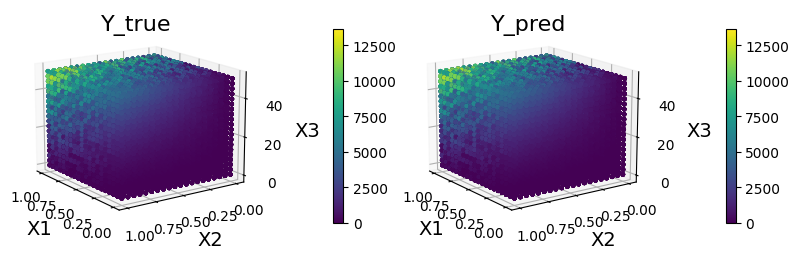

In [ ]:
#3D plots with fixed X4

fs = 14
fig = plt.figure(figsize = (8, 3))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
s1 = ax1.scatter(X1, X2, X3, c = Y_true, marker = '.')
cbar1 = fig.colorbar(s1, ax = ax1, fraction = 0.03, pad = 0.25)
ax1.view_init(15, 145)
ax1.set_title('Y_true', fontsize = fs + 2, y = 0.95)
ax1.set_xlabel('X1', fontsize = fs)
ax1.set_ylabel('X2', fontsize = fs)
ax1.set_zlabel('X3', fontsize = fs)

ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
s2 = ax2.scatter(X1, X2, X3, c = Y_pred, marker = '.')
cbar2 = fig.colorbar(s2, ax = ax2, fraction = 0.03, pad = 0.25)
ax2.view_init(15, 145)
ax2.set_title('Y_pred', fontsize = fs + 2, y = 0.95)
ax2.set_xlabel('X1', fontsize = fs)
ax2.set_ylabel('X2', fontsize = fs)
ax2.set_zlabel('X3', fontsize = fs)


plt.tight_layout()
plt.show()

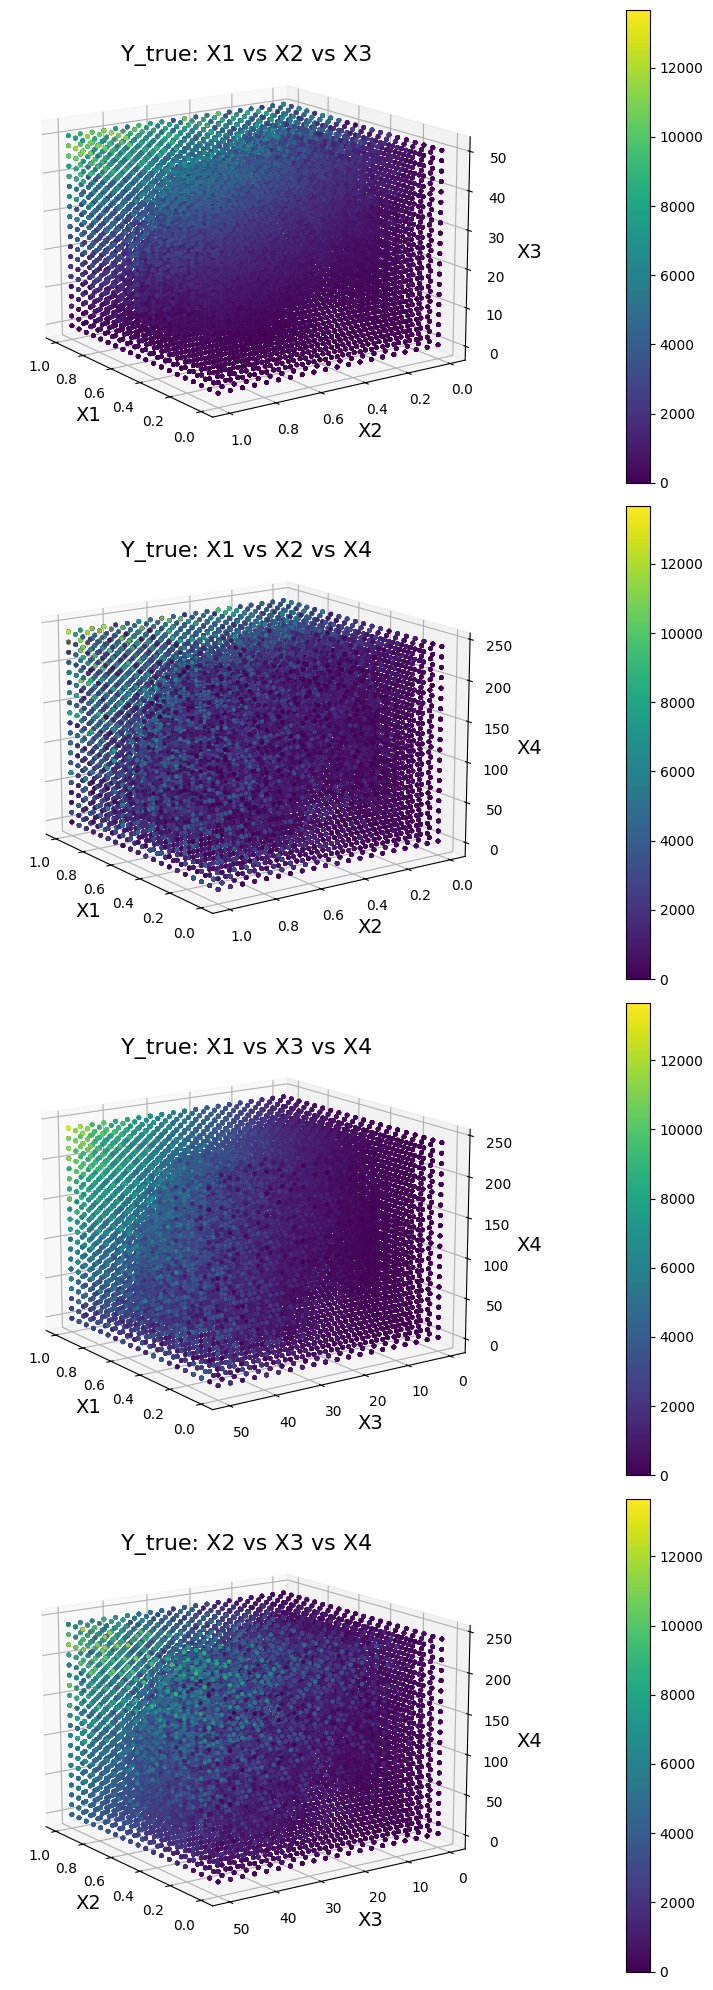

In [ ]:
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have 7 variables: X1, X2, X3, X4, X5, X6, X7, and Y_true.
# All variables should be arrays or lists with the same length.

X = [X1, X2, X3, X4]
variable_names = ['X1', 'X2', 'X3', 'X4']

# Create combinations of all unique triplets
combinations = list(itertools.combinations(range(4), 3))

# Plotting settings
fs = 14
fig = plt.figure(figsize=(15, len(combinations) * 5))  # Adjust figure size based on number of combinations

# Loop through each combination of variables
for i, (a, b, c) in enumerate(combinations):
    ax = fig.add_subplot(len(combinations), 1, i + 1, projection='3d')
    s = ax.scatter(X[a], X[b], X[c], c=Y_true, marker='.')
    cbar = fig.colorbar(s, ax=ax, fraction=0.03, pad=0.1)
    ax.view_init(15, 145)
    ax.set_title(f'Y_true: {variable_names[a]} vs {variable_names[b]} vs {variable_names[c]}', fontsize=fs + 2, y=0.95)
    ax.set_xlabel(variable_names[a], fontsize=fs)
    ax.set_ylabel(variable_names[b], fontsize=fs)
    ax.set_zlabel(variable_names[c], fontsize=fs)

plt.tight_layout()
plt.show()


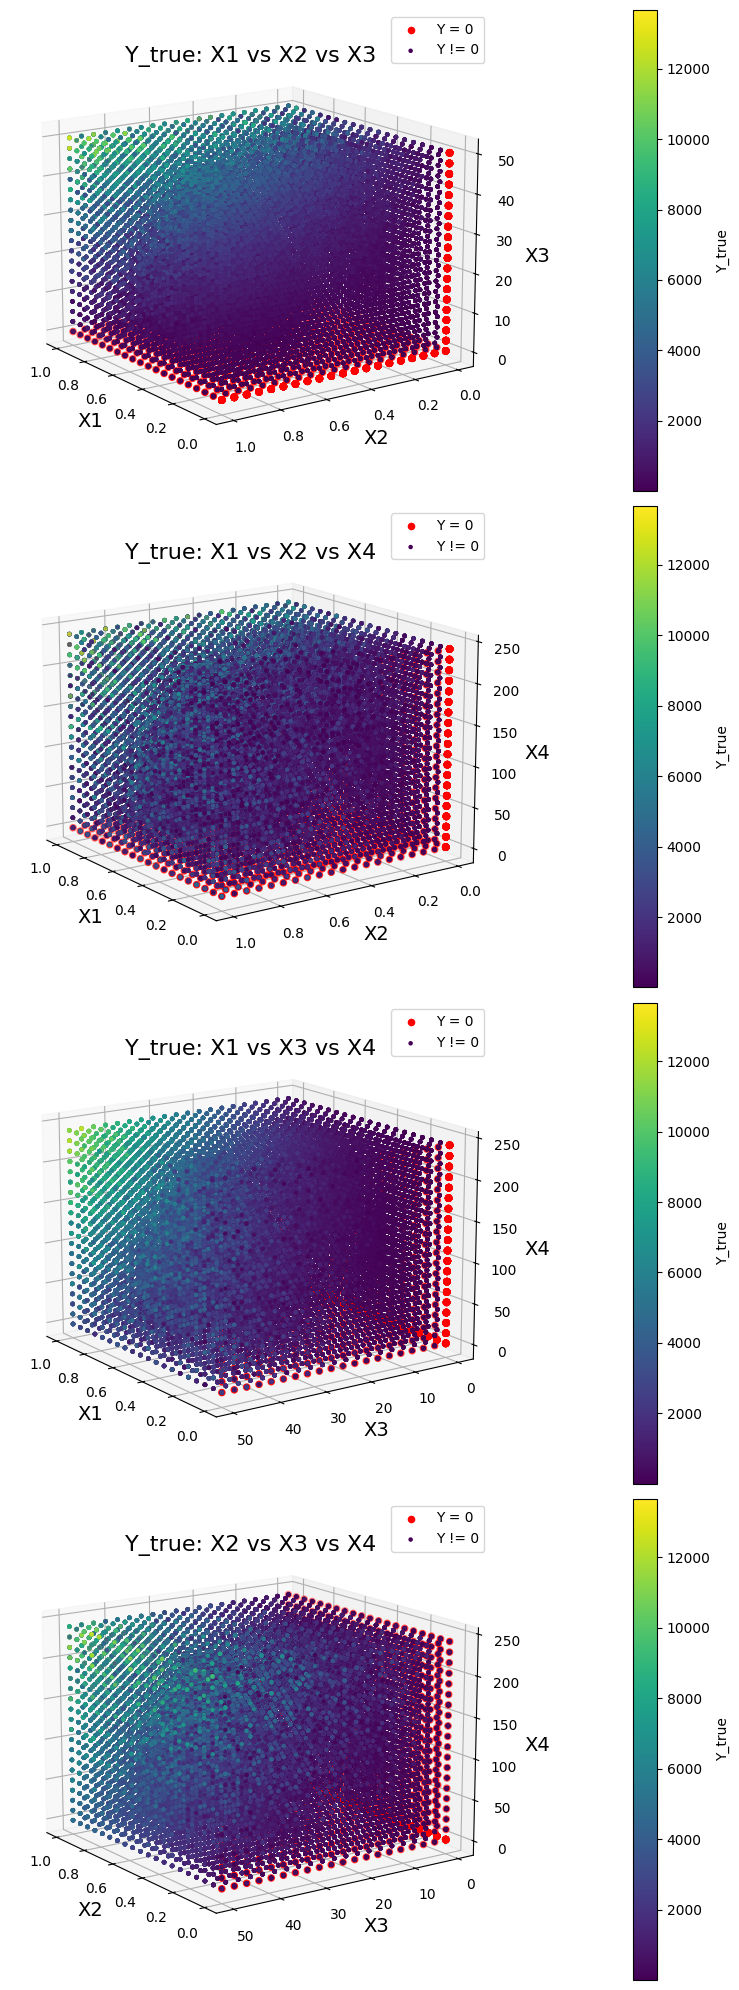

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: assuming you have 4 variables X1, X2, X3, X4, and a target variable Y_true.
# X1, X2, X3, X4, and Y_true should be arrays or lists of the same length.

X = [X1, X2, X3, X4]
variable_names = ['X1', 'X2', 'X3', 'X4']

# Create combinations of all unique triplets (since it's a 4-variable problem, it will create four 3D plots)
combinations = list(itertools.combinations(range(4), 3))

# Plotting settings
fs = 14
fig = plt.figure(figsize=(15, len(combinations) * 5))  # Adjust figure size based on number of combinations

# Loop through each combination of variables
for i, (a, b, c) in enumerate(combinations):
    ax = fig.add_subplot(len(combinations), 1, i + 1, projection='3d')
    
    # Mask for points where Y_true = 0
    mask = (Y_true == 0)
    
    # Plot points where Y_true = 0 in red
    s1 = ax.scatter(X[a][mask], X[b][mask], X[c][mask], c='red', marker='o', label='Y = 0')
    
    # Plot points where Y_true != 0 using a color map
    s2 = ax.scatter(X[a][~mask], X[b][~mask], X[c][~mask], c=Y_true[~mask], marker='.', cmap='viridis', label='Y != 0')
    
    # Add color bar for non-zero Y values
    cbar = fig.colorbar(s2, ax=ax, fraction=0.03, pad=0.1)
    cbar.set_label('Y_true')
    
    # Set view and labels
    ax.view_init(15, 145)
    ax.set_title(f'Y_true: {variable_names[a]} vs {variable_names[b]} vs {variable_names[c]}', fontsize=fs + 2, y=0.95)
    ax.set_xlabel(variable_names[a], fontsize=fs)
    ax.set_ylabel(variable_names[b], fontsize=fs)
    ax.set_zlabel(variable_names[c], fontsize=fs)
    
    # Add legend
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:

#GP model fucntion for slicing later
def PVD4(X):
    Y_pred, Y_pred_var = model.predict(X)
    X1 = np.array(X[:,0])
    X2 = np.array(X[:,1])
    X3 = np.array(X[:,2])
    X4 = np.array(X[:,3])
    Y_true = np.array(0.6224* X1* X3* X4 + 1.7781* X2* X3**2 + 3.1661* X1**2* X4 + 19.84* X1**2*X3)

    X1_flat = X1.flatten()
    X2_flat = X2.flatten()
    X3_flat = X3.flatten()
    X4_flat = X4.flatten()
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()

    # Create a DataFrame
    data = {
        'X1': X1_flat,
        'X2': X2_flat,
        'X3': X3_flat,
        'X4': X4_flat,
        'Y_true': Y_true_flat,
        'Y_pred': Y_pred_flat,
    }
    
    df = pd.DataFrame(data)
    df['G1'] = -X1_flat  + 0.0193*X3_flat 
    df['G2'] = -X2_flat  + 0.00954*X3_flat 
    x = (-np.pi*X3_flat**2*X4_flat - 4/3*np.pi*X3_flat**3 + 1296000)
    df['G3'] = np.where(x >= 0, np.log(1 + x), -np.log(1 - x))
    return df

In [ ]:
#DSp with the slicing tool
from DSp_tools import generate_input_samples, save_pkl, load_pkl

#declaring the problem info 
# Global variables
maxvp = 0

u = -0
#cons = {'Y_pred': [-1e20, 1e20], 'G1': [-1e20, u], 'G2': [-1e20, u], 'G3': [-1e20, u]} 
cons = {'Y_pred': [5804, 1e20],'G1': [-1e20, u], 'G2': [-1e20, u], 'G3': [-1e20, u]} 

#bounds = {'PVD4':    {'lb': [ ], 'ub': []}}
benchmark_problems = {'PVD4':    PVD4}
sv4D = ['X1', 'X2', 'X3', 'X4']
problem_sv = {'PVD4':    sv4D}


problem_list = ['PVD4']

opt_hidedsp = {'hidedsp': True, 'hidevio': True}
no_samples = 4096
#no_slices = 1
benchmark_sol_4DGP_PVD = {} #benchmark_sol_4DGP_PVD

#nominal point for analysis
NP = [0.9, 0.5, 49, 170] #midranges

opt_find_DSp = {'hidedsp': False, 'opt_amul': True, 'maxvp': maxvp, 'tol': -1e5, 'ub': 1, 'lb': 0} #bisection run bounds

In [ ]:

def get_Xconstliza(constant_dict, sv, lb, ub, no_samples, sampling_method, F_sam_plot):
    import numpy as np
    index_cut = []
    index_constant = []
    for l in sv:
        if l not in list(constant_dict.keys()):
            index_cut.append(sv.index(l))
        else:
            index_constant.append(sv.index(l))
    #print('getfun:const',index_constant, 'nonconst', index_cut)
    lb_cut = np.array(lb)[index_cut]
    ub_cut = np.array(ub)[index_cut]
    sv_cut = (np.array(sv)[index_cut]).tolist()
    #print('sv_cut', sv_cut)
    Xcut = Sobol_sequence(lb_cut, ub_cut)
    Xnew = np.zeros((Xcut.shape[0], len(sv)))
    Xnew[:, index_cut] = Xcut
    #print('Xnew before filling in constants', Xnew)
    Xnew[:, index_constant] = np.array([constant_dict[l] for l in list(constant_dict.keys())])
    #print('Xnew after filling in constants', Xnew)
    return Xnew, sv_cut

def get_slices_dfliza(no_slices, sv, lb, ub, no_samples, sampling_method, F_sam_plot, f, NP):
    import numpy as np
    import pandas as pd
    all_slices = []
    for slice_no in no_slices:
        #print('slice number',slice_no)
   
        constant_vars = [sv[slice_no]]
        ### ~ adapted to high D problem ~ ###
        #print('len(sv)',len(sv))
        if len(sv)>4:
            if slice_no < (len(sv)-1):
                constant_vars.append(sv[slice_no + 1])
            else:
                constant_vars.append(sv[0])
        #print('CONSTVAR',constant_vars)
        index_cut = []
        index_constant = []

        for l in sv:
            if l not in constant_vars:
                index_cut.append(sv.index(l))
            else:
                index_constant.append(sv.index(l))
        
        sv_constant = (np.array(sv)[index_constant]).tolist() 

        X_constant = (np.array(NP)[index_constant]).tolist() 
        #print('Xconst',X_constant)
        #print('sv', sv_constant)
        constant_dict = {}
        for i, l in enumerate(sv_constant):
            constant_dict[l] = X_constant[i]
            #print(constant_dict, X_constant)
        Xnew, sv_cut = get_Xconstliza(constant_dict, sv, lb, ub, no_samples, sampling_method, F_sam_plot)

        df = f(Xnew)
        df.insert(0, 'sv_cut', [sv_cut for i in range(df.shape[0])])
        df.insert(0, 'slice_no', slice_no)
        all_slices.append(df)
            
    all_slices = pd.concat(all_slices).reset_index(drop = True)
    return all_slices 

In [ ]:
#iterating through the slices


for problem_label in problem_list:
    print(problem_label)
    benchmark_sol_4DGP_PVD[problem_label] = {}
    f = benchmark_problems[problem_label]
    sv = problem_sv[problem_label]
    lb = xlimits[:,0]
    ub = xlimits[:,1]
    
    no_slices = range(len(sv))
   
    df_slices = get_slices_dfliza(no_slices, sv, lb, ub, no_samples, 'sobol', False, f, NP)
    for slice in no_slices:
        df = df_slices.copy()
        df = df[df['slice_no'] == slice]
        sv_slice = df['sv_cut'].iloc[0]
        
        ds = DSI(df)
        ds.screen(cons)
        ds.vnames = sv_slice
        ds.opt.update(opt_hidedsp)
        print('ds:', ds.df)
        if ds.sat.shape[0] == 0:
            print('No feasible points in slice ' + str(slice))
        else:
            #ds.find_DSp(sv_slice, opt = opt_find_DSp)
            #ds.plot(opt = {'hidevio': False})
            # Uncomment the above to find the DSp for each slice
            pass
        benchmark_sol_4DGP_PVD[problem_label][slice] = ds
save_pkl(benchmark_sol_4DGP_PVD, 'benchmark_sol_4DGP_PVD.pkl')

In [ ]:
#metrics
benchmark_sol_4DGP_PVD = load_pkl('benchmark_sol_4DGP_PVD.pkl')

for no_slice in range(len(list(benchmark_sol_4DGP_PVD[problem_label].keys()))):
        print(no_slice)
        ds = benchmark_sol_4DGP_PVD[problem_label][no_slice]
        YpredFlag = np.array(ds.df['SatFlag'], dtype=int)
        Ytrue = np.array(ds.df['Y_true'])
        G1 = np.array(ds.df['G1'])
        G2 = np.array(ds.df['G2'])
        G3 = np.array(ds.df['G3'])
        
        YtrueFlag = np.where(((Ytrue >= cons['Y_pred'][0]) & (Ytrue <= cons['Y_pred'][1]) &(G1 >= cons['G1'][0]) & (G1 <= cons['G1'][1]) \
                              & (G2 >= cons['G2'][0]) & (G2 <= cons['G2'][1])\
                                & (G3 >= cons['G3'][0]) & (G3 <= cons['G3'][1])), 1, 0)
        print(YtrueFlag)
        metrics = evaluate_metrics(YtrueFlag, YpredFlag)
        print(metrics)



Data loaded: benchmark_sol_4DGP_PVD.pkl
0
[0 0 0 ... 0 0 0]
[[15950     0]
 [    0   434]]
{'Confusion Matrix': array([[15950,     0],
       [    0,   434]], dtype=int64), 'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
1
[0 0 0 ... 0 0 0]
[[16236     0]
 [    0   148]]
{'Confusion Matrix': array([[16236,     0],
       [    0,   148]], dtype=int64), 'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
2
[0 0 0 ... 0 0 0]
[[16121     0]
 [    0   263]]
{'Confusion Matrix': array([[16121,     0],
       [    0,   263]], dtype=int64), 'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}
3
[0 0 0 ... 0 0 0]
[[16243     0]
 [    0   141]]
{'Confusion Matrix': array([[16243,     0],
       [    0,   141]], dtype=int64), 'Accuracy': 1.0, 'Recall': 1.0, 'Precision': 1.0, 'F1 Score': 1.0}


Data loaded: benchmark_sol_4DGP_PVD.pkl
['X2', 'X3', 'X4']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |       False        |         0          |     2.500e+00      
    2     |     3.750e+00      |       False        |         0          |     1.250e+00      
    3     |     4.375e+00      |       False        |         0          |     6.250e-01      
    4     |     4.688e+00      |       False        |         0          |     3.125e-01      
    5     |     4.844e+00      |       False        |         0          |     1.562e-01      
    6     |     4.922e+00      |   

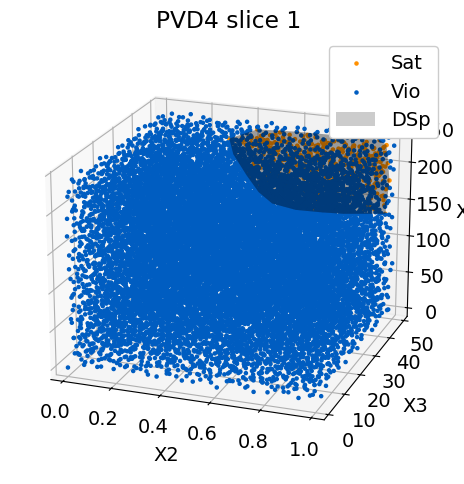

['X1', 'X3', 'X4']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |       False        |         0          |     2.500e+00      
    2     |     3.750e+00      |       False        |         0          |     1.250e+00      
    3     |     4.375e+00      |       False        |         0          |     6.250e-01      
    4     |     4.688e+00      |       False        |         0          |     3.125e-01      
    5     |     4.844e+00      |       False        |         0          |     1.562e-01      
    6     |     4.922e+00      |       False        |         0          | 

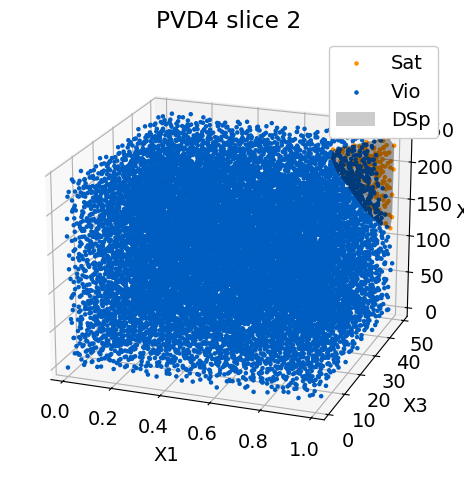

['X1', 'X2', 'X4']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |       False        |         0          |     2.500e+00      
    2     |     3.750e+00      |       False        |         0          |     1.250e+00      
    3     |     4.375e+00      |       False        |         0          |     6.250e-01      
    4     |     4.688e+00      |       False        |         0          |     3.125e-01      
    5     |     4.844e+00      |       False        |         0          |     1.562e-01      
    6     |     4.922e+00      |       False        |         0          | 

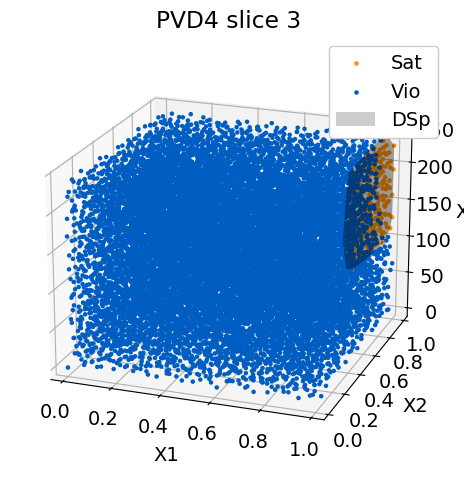

['X1', 'X2', 'X3']
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |       False        |         0          |     2.500e+00      
    2     |     3.750e+00      |       False        |         0          |     1.250e+00      
    3     |     4.375e+00      |       False        |         0          |     6.250e-01      
    4     |     4.688e+00      |       False        |         0          |     3.125e-01      
    5     |     4.844e+00      |       False        |         0          |     1.562e-01      
    6     |     4.922e+00      |       False        |         0          | 

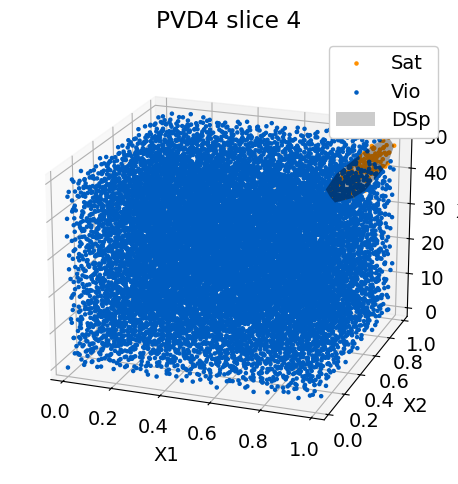

In [ ]:
#plotting the results
benchmark_sol_4DGP_PVD = load_pkl('benchmark_sol_4DGP_PVD.pkl')

for problem_label in ['PVD4']:
    for no_slice in range(len(list(benchmark_sol_4DGP_PVD[problem_label].keys()))):
        opt_hidedsp = {'hidedsp': False, 'hidevio': False}
        ds = benchmark_sol_4DGP_PVD[problem_label][no_slice]
        sv = ds.df['sv_cut'].iloc[0]
        print(sv)
        ds.plot(sv, opt = opt_hidedsp)
        plt.title(problem_label + ' slice ' + str(no_slice+1))
        plt.show()